## Importing packages to use in order to create the visulizations

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', 100)

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import re
import string
import nltk
import xgboost

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV

import sys


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix

from textblob import TextBlob, Word
from wordcloud import WordCloud

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/elliott/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Reading in the Data 
#### Doing simple Data processing to prepare it for the visulizations, like running it through a function to use stop words and break on white space

In [3]:
data = pd.read_csv("../../../data/thanos.csv")
data.head()


,steamid,appid,app_title,app_tags,review,fps,voted_up
0,76561198271088129,4000,Garry's Mod,"['Sandbox', 'Multiplayer', 'Funny', 'Moddable', 'Building', 'Comedy', 'Co-op', 'Mod', 'First-Per...",good models\n,True,True
1,76561198138206834,4000,Garry's Mod,"['Sandbox', 'Multiplayer', 'Funny', 'Moddable', 'Building', 'Comedy', 'Co-op', 'Mod', 'First-Per...",I completely suck at making anything on here and death run keeps ending in countless deaths beca...,True,True
2,76561198128760839,70,Half-Life,"['FPS', 'Sci-fi', 'Action', 'Singleplayer', ""1990's"", 'Shooter', 'Multiplayer', 'First-Person', ...",There is not much to say about this old game that hasn't been said really. Many people have play...,True,True
3,76561198079636858,6060,"Star Wars: Battlefront 2 (Classic, 2005)","['Action', 'Multiplayer', 'Shooter', 'Third-Person Shooter', 'Classic', 'Sci-fi', 'Space', 'FPS'...",360 noscoped almost everything 10/10 even the single player is fun...,True,True
4,76561198238100200,220,Half-Life 2,"['FPS', 'Action', 'Sci-fi', 'Classic', 'Singleplayer', 'Story Rich', 'Shooter', 'First-Person', ...",No need for a review. It's practically history.,True,True


In [4]:
data["voted_up"] = data["voted_up"].astype(int)

data.head()

,steamid,appid,app_title,app_tags,review,fps,voted_up
0,76561198271088129,4000,Garry's Mod,"['Sandbox', 'Multiplayer', 'Funny', 'Moddable', 'Building', 'Comedy', 'Co-op', 'Mod', 'First-Per...",good models\n,True,1
1,76561198138206834,4000,Garry's Mod,"['Sandbox', 'Multiplayer', 'Funny', 'Moddable', 'Building', 'Comedy', 'Co-op', 'Mod', 'First-Per...",I completely suck at making anything on here and death run keeps ending in countless deaths beca...,True,1
2,76561198128760839,70,Half-Life,"['FPS', 'Sci-fi', 'Action', 'Singleplayer', ""1990's"", 'Shooter', 'Multiplayer', 'First-Person', ...",There is not much to say about this old game that hasn't been said really. Many people have play...,True,1
3,76561198079636858,6060,"Star Wars: Battlefront 2 (Classic, 2005)","['Action', 'Multiplayer', 'Shooter', 'Third-Person Shooter', 'Classic', 'Sci-fi', 'Space', 'FPS'...",360 noscoped almost everything 10/10 even the single player is fun...,True,1
4,76561198238100200,220,Half-Life 2,"['FPS', 'Action', 'Sci-fi', 'Classic', 'Singleplayer', 'Story Rich', 'Shooter', 'First-Person', ...",No need for a review. It's practically history.,True,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23183 entries, 0 to 23182
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   steamid    23183 non-null  int64 
 1   appid      23183 non-null  int64 
 2   app_title  23183 non-null  object
 3   app_tags   23183 non-null  object
 4   review     23183 non-null  object
 5   fps        23183 non-null  bool  
 6   voted_up   23183 non-null  int64 
dtypes: bool(1), int64(3), object(3)
memory usage: 1.1+ MB


In [6]:
data["voted_up"].value_counts(normalize=True)

1    0.505888
0    0.494112
Name: voted_up, dtype: float64

In [7]:
def CleanText(reviews):
    stopwords = nltk.corpus.stopwords.words('english')
    punct = string.punctuation
    lemma = nltk.WordNetLemmatizer()
    
    reviews = "".join([word for word in reviews if word not in string.punctuation])
    tokens = re.split('\W+', reviews)
    reviews = [lemma.lemmatize(word) for word in tokens if word not in stopwords]
    
# use function like this in your notebook
# df['cleaned_text'] = df['text'].apply(lambda x: CleanText(x.lower()))
    
    return reviews


In [8]:
data['clean_review'] = data['review'].apply(lambda x: CleanText(x.lower()))

data.head()

,steamid,appid,app_title,app_tags,review,fps,voted_up,clean_review
0,76561198271088129,4000,Garry's Mod,"['Sandbox', 'Multiplayer', 'Funny', 'Moddable', 'Building', 'Comedy', 'Co-op', 'Mod', 'First-Per...",good models\n,True,1,"[good, model, ]"
1,76561198138206834,4000,Garry's Mod,"['Sandbox', 'Multiplayer', 'Funny', 'Moddable', 'Building', 'Comedy', 'Co-op', 'Mod', 'First-Per...",I completely suck at making anything on here and death run keeps ending in countless deaths beca...,True,1,"[completely, suck, making, anything, death, run, keep, ending, countless, death, suck, jumping, ..."
2,76561198128760839,70,Half-Life,"['FPS', 'Sci-fi', 'Action', 'Singleplayer', ""1990's"", 'Shooter', 'Multiplayer', 'First-Person', ...",There is not much to say about this old game that hasn't been said really. Many people have play...,True,1,"[much, say, old, game, hasnt, said, really, many, people, played, halflife, 2, episode, sometime..."
3,76561198079636858,6060,"Star Wars: Battlefront 2 (Classic, 2005)","['Action', 'Multiplayer', 'Shooter', 'Third-Person Shooter', 'Classic', 'Sci-fi', 'Space', 'FPS'...",360 noscoped almost everything 10/10 even the single player is fun...,True,1,"[360, noscoped, almost, everything, 1010, even, single, player, fun]"
4,76561198238100200,220,Half-Life 2,"['FPS', 'Action', 'Sci-fi', 'Classic', 'Singleplayer', 'Story Rich', 'Shooter', 'First-Person', ...",No need for a review. It's practically history.,True,1,"[need, review, practically, history]"


##### creating new variables based off a 1 or 0 vote by users

In [9]:
df_down = data.loc[data['voted_up'] == 0]
df_up = data.loc[data['voted_up'] == 1]

##### Creating WordClouds and TextBlobs for both up and down votes

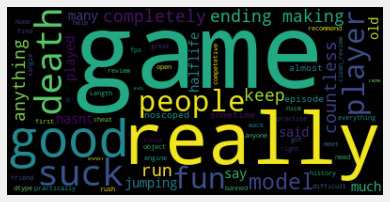

<Figure size 1440x720 with 0 Axes>

In [10]:
wordcloud = WordCloud(max_words=10000, width=400, height=200).generate(str(df_up["clean_review"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

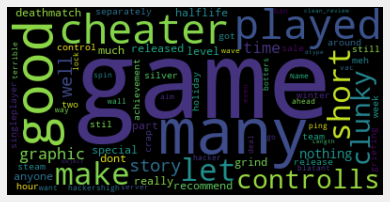

<Figure size 1440x720 with 0 Axes>

In [11]:
wordcloud = WordCloud(max_words=10000, width=400, height=200).generate(str(df_down["clean_review"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/elliott/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Text(0, 0.5, 'Number of occurence')

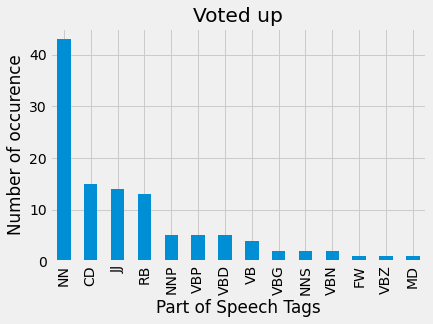

In [13]:
blob = TextBlob(str(df_up["clean_review"]))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(kind='bar', title="Voted up" )
plt.xlabel("Part of Speech Tags")
plt.ylabel("Number of occurence")


Text(0, 0.5, 'Number of occurence')

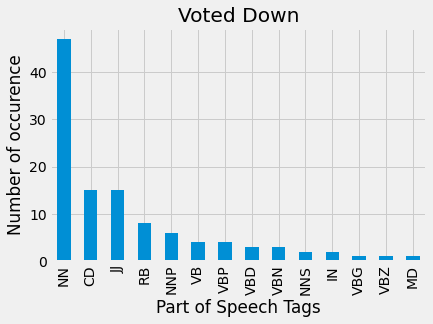

In [14]:
blob = TextBlob(str(df_down["clean_review"]))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(kind='bar', title="Voted Down" )
plt.xlabel("Part of Speech Tags")
plt.ylabel("Number of occurence")

